In [ ]:
import torch
from torch import nn
from torch.nn.modules.activation import ReLU
from torch.cuda.amp import autocast, GradScaler

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split, Dataset, DataLoader
import torchvision.transforms as transforms
import kagglehub
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


Dataset

In [ ]:
DATA_DIR = kagglehub.dataset_download("jaimetrickz/galaxy-zoo-2-images")


Using Colab cache for faster access to the 'galaxy-zoo-2-images' dataset.


In [ ]:
os.listdir(DATA_DIR)

['gz2_filename_mapping.csv', 'images_gz2']

In [ ]:
csv_path = os.path.join(DATA_DIR, "gz2_filename_mapping.csv")
df = pd.read_csv(csv_path)

df.head()

,objid,sample,asset_id
0,587722981736120347,original,1
1,587722981736579107,original,2
2,587722981741363294,original,3
3,587722981741363323,original,4
4,587722981741559888,original,5


In [ ]:
df.columns


Index(['objid', 'sample', 'asset_id'], dtype='object')

In [ ]:
os.listdir(os.path.join(DATA_DIR, "images_gz2"))


['images']

In [ ]:
!wget -O /content/gz2_hart16.csv.gz https://gz2hart.s3.amazonaws.com/gz2_hart16.csv.gz
!gunzip -f /content/gz2_hart16.csv.gz


--2026-02-23 01:22:40--  https://gz2hart.s3.amazonaws.com/gz2_hart16.csv.gz
Resolving gz2hart.s3.amazonaws.com (gz2hart.s3.amazonaws.com)... 16.15.183.212, 54.231.202.217, 52.216.33.49, ...
Connecting to gz2hart.s3.amazonaws.com (gz2hart.s3.amazonaws.com)|16.15.183.212|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78513011 (75M) [application/x-gzip]
Saving to: ‘/content/gz2_hart16.csv.gz’

/content/gz2_hart16 100%[===================>]  74.88M  15.4MB/s    in 6.2s    

2026-02-23 01:22:47 (12.1 MB/s) - ‘/content/gz2_hart16.csv.gz’ saved [78513011/78513011]



In [ ]:
DATA_DIR = DATA_DIR
IMG_DIR = os.path.join(DATA_DIR, "images_gz2", "images")

mapping = pd.read_csv(os.path.join(DATA_DIR, "gz2_filename_mapping.csv"))
hart = pd.read_csv("/content/gz2_hart16.csv", low_memory=False)

hart = hart.rename(columns={"dr7objid": "objid"})
mapping["objid"] = pd.to_numeric(mapping["objid"], errors="coerce")
hart["objid"] = pd.to_numeric(hart["objid"], errors="coerce")

merged = mapping.merge(hart, on="objid", how="inner")
print("merged:", merged.shape)
merged.head()


merged: (239695, 233)


,objid,sample_x,asset_id,ra,dec,rastring,decstring,sample_y,gz2_class,total_classifications,...,t11_arms_number_a36_more_than_4_fraction,t11_arms_number_a36_more_than_4_weighted_fraction,t11_arms_number_a36_more_than_4_debiased,t11_arms_number_a36_more_than_4_flag,t11_arms_number_a37_cant_tell_count,t11_arms_number_a37_cant_tell_weight,t11_arms_number_a37_cant_tell_fraction,t11_arms_number_a37_cant_tell_weighted_fraction,t11_arms_number_a37_cant_tell_debiased,t11_arms_number_a37_cant_tell_flag
0,587722981741363294,original,3,182.925262,-1.092357,12:11:42.06,-01:05:32.5,original,Sb,52,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
1,587722981741363323,original,4,182.970108,-1.219537,12:11:52.83,-01:13:10.3,original,Sc?l,30,...,0.0,0.0,0.0,0,1,1.0,1.0,1.0,1.0,1
2,587722981741559888,original,5,183.438095,-1.238414,12:13:45.14,-01:14:18.3,original,Er,53,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
3,587722981741625481,original,6,183.473999,-1.231429,12:13:53.76,-01:13:53.1,original,Sc1t,37,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
4,587722981741625484,original,7,183.477783,-1.084604,12:13:54.67,-01:05:04.6,original,Sb,45,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0


In [ ]:
def resolve_img_path(asset_id: str):
    candidates = [
        os.path.join(IMG_DIR, str(asset_id)),
        os.path.join(IMG_DIR, f"{asset_id}.jpg"),
        os.path.join(IMG_DIR, f"{asset_id}.png"),
        os.path.join(IMG_DIR, f"{asset_id}.jpeg"),
    ]
    for p in candidates:
        if os.path.exists(p):
            return p
    return None

merged["image_path"] = merged["asset_id"].apply(resolve_img_path)
missing = merged["image_path"].isna().mean()
print("missing image paths:", missing)

merged = merged.dropna(subset=["image_path"]).reset_index(drop=True)
print("after drop missing:", merged.shape)

missing image paths: 0.0005089801622895763
after drop missing: (239573, 234)


In [ ]:

smooth = "t01_smooth_or_features_a01_smooth_debiased"
disk   = "t01_smooth_or_features_a02_features_or_disk_debiased"
star   = "t01_smooth_or_features_a03_star_or_artifact_debiased"

edge_y = "t02_edgeon_a04_yes_debiased"
edge_n = "t02_edgeon_a05_no_debiased"

spiral = "t04_spiral_a08_spiral_debiased"

df = merged.copy()
df = df[df["total_classifications"] >= 10]
df = df[df[star] < 0.5]
df = df.reset_index(drop=True)

T = 0.8

label = np.full(len(df), -1, dtype=int)

is_ell = (df[smooth] >= T)

is_edge = (df[disk] >= T) & (df[edge_y] >= T)
is_sp   = (df[disk] >= T) & (df[edge_n] >= T) & (df[spiral] >= T)

label[is_ell]  = 0
label[is_sp]   = 1
label[is_edge] = 2

# "irregular/other"
label[label == -1] = 3

df["label_id"] = label
id2name = {0:"elliptical", 1:"spiral", 2:"edge_on_disk", 3:"irregular_other"}
df["label_name"] = df["label_id"].map(id2name)

print(df["label_name"].value_counts())
df[["image_path","label_id","label_name", smooth, disk, edge_y, edge_n, spiral]].head()


label_name
irregular_other    107291
spiral              69721
elliptical          53191
edge_on_disk         9364
Name: count, dtype: int64


,image_path,label_id,label_name,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a02_features_or_disk_debiased,t02_edgeon_a04_yes_debiased,t02_edgeon_a05_no_debiased,t04_spiral_a08_spiral_debiased
0,/kaggle/input/galaxy-zoo-2-images/images_gz2/i...,3,irregular_other,0.459,0.681,0.041914,0.914402,0.000000
1,/kaggle/input/galaxy-zoo-2-images/images_gz2/i...,3,irregular_other,0.216,0.736,0.000000,1.000000,0.751993
2,/kaggle/input/galaxy-zoo-2-images/images_gz2/i...,3,irregular_other,0.773,0.029,0.000000,1.000000,0.000000
3,/kaggle/input/galaxy-zoo-2-images/images_gz2/i...,3,irregular_other,0.152,0.639,0.000000,1.000000,0.692553
4,/kaggle/input/galaxy-zoo-2-images/images_gz2/i...,3,irregular_other,0.182,0.720,0.000000,1.000000,0.000000


In [ ]:
out = df[["image_path","label_id","label_name","objid","asset_id","total_classifications",
          smooth, disk, edge_y, edge_n, spiral]].copy()

out_path = "/content/galaxy_level2.csv"
out.to_csv(out_path, index=False)
print("saved:", out_path, "rows:", len(out))


saved: /content/galaxy_level2.csv rows: 239567


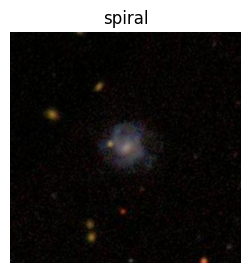

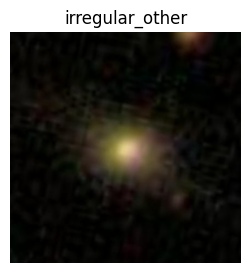

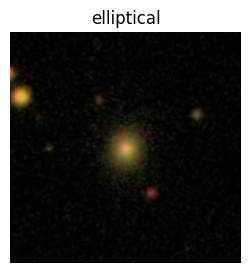

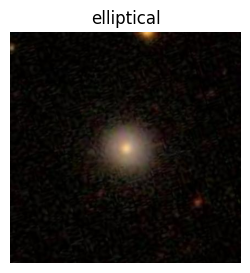

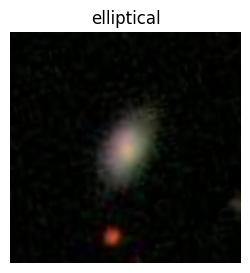

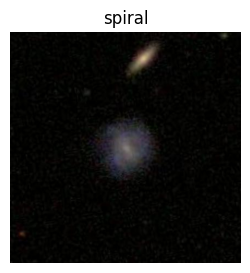

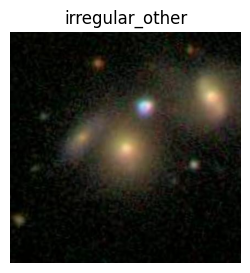

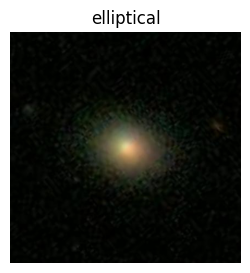

In [ ]:

for _ in range(8):
    r = out.sample(1).iloc[0]
    img = Image.open(r["image_path"])
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(r["label_name"])
    plt.show()


In [ ]:
csv_path = "/content/galaxy_level2.csv"
data = pd.read_csv(csv_path)
data = data[["image_path", "label_id"]].dropna().reset_index(drop=True)


train_df, temp_df = train_test_split(
    data,
    test_size=0.30,
    random_state=42,
    shuffle=True,
    stratify=data["label_id"],
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    shuffle=True,
    stratify=temp_df["label_id"],
)

print(len(train_df), len(val_df), len(test_df))
print(train_df["label_id"].value_counts(normalize=True).sort_index())
print(val_df["label_id"].value_counts(normalize=True).sort_index())
print(test_df["label_id"].value_counts(normalize=True).sort_index())


167696 35935 35936
label_id
0    0.222033
1    0.291027
2    0.039089
3    0.447852
Name: proportion, dtype: float64
label_id
0    0.222012
1    0.291025
2    0.039098
3    0.447864
Name: proportion, dtype: float64
label_id
0    0.222034
1    0.291045
2    0.039069
3    0.447852
Name: proportion, dtype: float64


In [ ]:
class GalaxyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        y = torch.tensor(int(row["label_id"]), dtype=torch.long)
        return img, y


In [ ]:
IMG_SIZE = 128

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(180),
    transforms.ToTensor(),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [ ]:
BATCH_SIZE = 64
NUM_WORKERS = 2

train_ds = GalaxyDataset(train_df, transform=train_tfms)
val_ds   = GalaxyDataset(val_df,   transform=eval_tfms)
test_ds  = GalaxyDataset(test_df,  transform=eval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

xb, yb = next(iter(train_loader))
print("xb:", xb.shape, xb.dtype, xb.min().item(), xb.max().item())
print("yb:", yb.shape, yb.dtype, yb[:10].tolist())
print("device ready:", torch.cuda.is_available())

xb: torch.Size([64, 3, 128, 128]) torch.float32 0.0 1.0
yb: torch.Size([64]) torch.int64 [2, 3, 0, 3, 3, 3, 0, 0, 0, 3]
device ready: True


Model

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"

class GalaxyModelV1(nn.Module):
    def __init__(self, in_ch=3, hidden=32, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, hidden, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(hidden, hidden*2, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(hidden*2, hidden*4, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(hidden*4, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


torch.manual_seed(42)
model_1 = GalaxyModelV1().to(device)
model_1


GalaxyModelV1(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_1 = model_1.to(device)

counts = train_df["label_id"].value_counts().sort_index().to_numpy()
w = (1.0 / torch.tensor(counts, dtype=torch.float))
w = w / w.sum() * len(counts)
loss_fn = nn.CrossEntropyLoss(weight=w.to(device))

optimizer = torch.optim.AdamW(model_1.parameters(), lr=3e-4, weight_decay=1e-2)

torch.backends.cudnn.benchmark = True
scaler = GradScaler(enabled=(device == "cuda"))

def run_epoch(model, loader, train: bool):
    model.train(train)
    total_loss, correct, n = 0.0, 0, 0

    for X, y in loader:
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=(device == "cuda")):
                logits = model(X)
                loss = loss_fn(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad():
                with autocast(enabled=(device == "cuda")):
                    logits = model(X)
                    loss = loss_fn(logits, y)

        bs = X.size(0)
        total_loss += loss.item() * bs
        correct += (logits.argmax(1) == y).sum().item()
        n += bs

    return total_loss / n, correct / n


EPOCHS = 5
best_val = float("inf")

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_epoch(model_1, train_loader, train=True)
    val_loss, val_acc     = run_epoch(model_1, val_loader,   train=False)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model_1.state_dict(), "/content/best_galaxy_model.pt")
        print("  saved -> /content/best_galaxy_model.pt")

print("best val loss:", best_val)


Load

In [ ]:
model_1.load_state_dict(torch.load("/content/best_galaxy_model.pt", map_location=device))
model_1 = model_1.to(device)

def eval_epoch(model, loader):
    model.eval()
    total_loss, correct, n = 0.0, 0, 0
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            with autocast(enabled=(device=="cuda")):
                logits = model(X)
                loss = loss_fn(logits, y)
            bs = X.size(0)
            total_loss += loss.item() * bs
            correct += (logits.argmax(1) == y).sum().item()
            n += bs
    return total_loss / n, correct / n

test_loss, test_acc = eval_epoch(model_1, test_loader)
print(f"TEST | loss {test_loss:.4f} | acc {test_acc:.4f}")

NameError: name 'model_1' is not defined

In [ ]:

y_true, y_pred = [], []

model_1.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device, non_blocking=True)
        logits = model_1(X)
        preds = logits.argmax(1).cpu().numpy()
        y_pred.append(preds)
        y_true.append(y.numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

id2name = {0:"elliptical", 1:"spiral", 2:"edge_on_disk", 3:"irregular_other"}
names = [id2name[i] for i in range(4)]
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=names, digits=4))

In [ ]:
test_df_reset = test_df.reset_index(drop=True).copy()
test_df_reset["pred_id"] = y_pred
wrong_idx = np.where(test_df_reset["label_id"].to_numpy() != test_df_reset["pred_id"].to_numpy())[0]
print("Wrong predictions:", len(wrong_idx), "out of", len(test_df_reset))

show = random.sample(list(wrong_idx), k=min(20, len(wrong_idx)))
for i in show:
    row = test_df_reset.iloc[i]
    img = Image.open(row["image_path"]).convert("RGB")
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"true={id2name[int(row['label_id'])]} | pred={id2name[int(row['pred_id'])]}")
    plt.show()

Version 2

In [ ]:
!pip -q install wandb
import wandb
wandb.login()

run = wandb.init(
    project="galaxy-zoo-v2",
    config={"lr": 3e-4, "model": "resnet18"}
)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
# === V2
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

class MemorizerCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16
        )
        self.head = nn.Sequential(
            nn.Flatten(),                          # 256*16*16 = 65536 features
            nn.Linear(256*16*16, 512), nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.head(x)

torch.manual_seed(42)
model_tiny = MemorizerCNN().to(device)

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_tiny.parameters(), lr=1e-3)

for epoch in range(1, 201):
    model_tiny.train()
    correct = n = 0
    total_loss = 0.0

    for X, y in tiny_loader:
        X, y = X.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model_tiny(X)
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()

        bs = X.size(0)
        total_loss += loss.item() * bs
        correct += (logits.argmax(1) == y).sum().item()
        n += bs

    acc = correct / n
    print(f"epoch {epoch:03d} | loss {total_loss/n:.4f} | acc {acc:.4f}")
    wandb.log({
    "train_loss": trL,
    "train_acc":  trA,
    "val_loss":   vaL,
    "val_acc":    vaA,
    "vram_gb":    mem_gb,
    "batch_size": BATCH_SIZE,
    "img_size":   IMG_SIZE,
    }, step=ep)

    if acc >= 0.95:
        print("✅ PASSED: can memorize 128 (pipeline OK)")
        break


NameError: name 'tiny_loader' is not defined

In [ ]:
data = pd.read_csv("/content/galaxy_level2.csv")

data_v2 = data[data["label_id"].isin([0,1,2])].copy().reset_index(drop=True)

remap = {0:0, 1:1, 2:2}
data_v2["label_id"] = data_v2["label_id"].map(remap)

train_df, temp_df = train_test_split(
    data_v2[["image_path","label_id"]],
    test_size=0.30,
    random_state=42,
    stratify=data_v2["label_id"],
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df["label_id"],
)

print(train_df["label_id"].value_counts(normalize=True).sort_index())


label_id
0    0.402125
1    0.527081
2    0.070794
Name: proportion, dtype: float64


In [ ]:
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, WeightedRandomSampler

IMG_SIZE = 128

train_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

eval_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_ds = GalaxyDataset(train_df, transform=train_tfms)
val_ds   = GalaxyDataset(val_df,   transform=eval_tfms)
test_ds  = GalaxyDataset(test_df,  transform=eval_tfms)

counts = train_df["label_id"].value_counts().sort_index().to_numpy()
class_w = 1.0 / torch.tensor(counts, dtype=torch.float)
sample_w = class_w[train_df["label_id"].to_numpy()]
sampler = WeightedRandomSampler(weights=sample_w, num_samples=len(sample_w), replacement=True)

train_loader = DataLoader(train_ds, batch_size=128, sampler=sampler, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

model_v2 = torchvision.models.resnet18(weights="DEFAULT")
model_v2.fc = nn.Linear(model_v2.fc.in_features, 3)
model_v2 = model_v2.to(device)


In [ ]:
import os, time, gc
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision
import torchvision.transforms as T
from PIL import Image
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda", "Runtime → Change runtime type → GPU"

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

amp_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
use_scaler = (amp_dtype == torch.float16)
scaler = torch.cuda.amp.GradScaler(enabled=use_scaler)

CSV_PATH = "/content/galaxy_level2.csv"
assert os.path.exists(CSV_PATH), f"Missing {CSV_PATH}. Build it first."

class GalaxyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        img = Image.open(r["image_path"]).convert("RGB")
        if self.transform: img = self.transform(img)
        y = torch.tensor(int(r["label_id"]), dtype=torch.long)
        return img, y

data = pd.read_csv(CSV_PATH)[["image_path","label_id"]].dropna()
data = data[data["label_id"].isin([0,1,2])].copy().reset_index(drop=True)
data["label_id"] = data["label_id"].astype(int)

train_df, temp_df = train_test_split(
    data, test_size=0.30, random_state=SEED, shuffle=True, stratify=data["label_id"]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=SEED, shuffle=True, stratify=temp_df["label_id"]
)

print("splits:", len(train_df), len(val_df), len(test_df))
print("train dist:", train_df["label_id"].value_counts(normalize=True).sort_index().to_dict())


IMG_SIZE = 224

train_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
eval_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_ds = GalaxyDataset(train_df, transform=train_tfms)
val_ds   = GalaxyDataset(val_df,   transform=eval_tfms)
test_ds  = GalaxyDataset(test_df,  transform=eval_tfms)

counts = train_df["label_id"].value_counts().sort_index().to_numpy()
class_w = 1.0 / torch.tensor(counts, dtype=torch.float32)
sample_w = class_w[train_df["label_id"].to_numpy()]
sampler = WeightedRandomSampler(weights=sample_w, num_samples=len(sample_w), replacement=True)

model = torchvision.models.resnet18(weights="DEFAULT")
model.fc = nn.Linear(model.fc.in_features, 3)
model = model.to(device).to(memory_format=torch.channels_last)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)

def _try_micro_bs(bs: int) -> bool:
    try:
        torch.cuda.empty_cache()
        gc.collect()
        model.train()
        optimizer.zero_grad(set_to_none=True)

        x = torch.randn(bs, 3, IMG_SIZE, IMG_SIZE, device=device, dtype=torch.float32)
        x = x.contiguous(memory_format=torch.channels_last)
        y = torch.randint(0, 3, (bs,), device=device)

        with torch.autocast(device_type="cuda", dtype=amp_dtype):
            logits = model(x)
            loss = loss_fn(logits, y)

        if use_scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        torch.cuda.synchronize()
        del x, y, logits, loss
        return True

    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            optimizer.zero_grad(set_to_none=True)
            torch.cuda.empty_cache()
            gc.collect()
            return False
        raise

def find_safe_micro_bs(start=64, max_try=8192, safety=0.90):
    bs = start
    last_ok = None
    while bs <= max_try and _try_micro_bs(bs):
        last_ok = bs
        bs *= 2

    if last_ok is None:
        return 16

    lo, hi = last_ok, bs - 1

    while lo < hi:
        mid = (lo + hi + 1) // 2
        if _try_micro_bs(mid):
            lo = mid
        else:
            hi = mid - 1

    return max(16, int(lo * safety))

MICRO_BS = find_safe_micro_bs(start=64, safety=0.90)
print("safe micro-batch:", MICRO_BS)

CPU = os.cpu_count() or 2
NUM_WORKERS = min(6, max(2, CPU // 2))
PREFETCH = 2

def make_loader(ds, train: bool):
    kwargs = dict(
        batch_size=MICRO_BS,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        persistent_workers=(NUM_WORKERS > 0),
        drop_last=train,
    )
    if NUM_WORKERS > 0:
        kwargs["prefetch_factor"] = PREFETCH
    if train:
        return DataLoader(ds, sampler=sampler, shuffle=False, **kwargs)
    return DataLoader(ds, shuffle=False, **kwargs)

train_loader = make_loader(train_ds, train=True)
val_loader   = make_loader(val_ds,   train=False)
test_loader  = make_loader(test_ds,  train=False)

TARGET_EFFECTIVE_BS = 1024
ACCUM_STEPS = max(1, TARGET_EFFECTIVE_BS // MICRO_BS)
print("accum steps:", ACCUM_STEPS, "| effective batch:", MICRO_BS * ACCUM_STEPS)

def train_epoch():
    model.train()
    total_loss, correct, n = 0.0, 0, 0
    optimizer.zero_grad(set_to_none=True)

    for step, (X, y) in enumerate(train_loader):
        X = X.to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
        y = y.to(device, non_blocking=True)

        try:
            with torch.autocast(device_type="cuda", dtype=amp_dtype):
                logits = model(X)
                loss = loss_fn(logits, y) / ACCUM_STEPS

            if use_scaler:
                scaler.scale(loss).backward()
            else:
                loss.backward()

            bs = X.size(0)
            total_loss += float(loss.item()) * bs * ACCUM_STEPS
            correct += (logits.argmax(1) == y).sum().item()
            n += bs

            if (step + 1) % ACCUM_STEPS == 0:
                if use_scaler:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
                optimizer.zero_grad(set_to_none=True)

        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print("OOM spike caught; skipping this micro-batch (safe continue).")
                optimizer.zero_grad(set_to_none=True)
                torch.cuda.empty_cache()
                continue
            raise

    if (step + 1) % ACCUM_STEPS != 0:
        if use_scaler:
            scaler.step(optimizer)
            scaler.update()
        else:
            optimizer.step()
        optimizer.zero_grad(set_to_none=True)

    return total_loss / n, correct / n

@torch.no_grad()
def eval_epoch(loader):
    model.eval()
    total_loss, correct, n = 0.0, 0, 0
    for X, y in loader:
        X = X.to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
        y = y.to(device, non_blocking=True)
        with torch.autocast(device_type="cuda", dtype=amp_dtype):
            logits = model(X)
            loss = loss_fn(logits, y)
        bs = X.size(0)
        total_loss += float(loss.item()) * bs
        correct += (logits.argmax(1) == y).sum().item()
        n += bs
    return total_loss / n, correct / n

EPOCHS = 5
SAVE_PATH = "/content/best_galaxy_v2_3class_SAFE.pt"
best_val = float("inf")

for ep in range(1, EPOCHS + 1):
    torch.cuda.reset_peak_memory_stats()
    t0 = time.time()

    trL, trA = train_epoch()
    vaL, vaA = eval_epoch(val_loader)

    mem_gb = torch.cuda.max_memory_allocated() / (1024**3)
    dt = time.time() - t0

    print(f"ep{ep:02d} | train {trL:.4f}/{trA:.4f} | val {vaL:.4f}/{vaA:.4f} | VRAM {mem_gb:.2f} GB | {dt:.1f}s")

    if vaL < best_val:
        best_val = vaL
        torch.save(model.state_dict(), SAVE_PATH)
        print("  saved ->", SAVE_PATH)

print("best val loss:", best_val)

model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
teL, teA = eval_epoch(test_loader)
print(f"TEST | loss {teL:.4f} | acc {teA:.4f}")

/tmp/ipython-input-2377529721.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_scaler)


splits: 92593 19841 19842
train dist: {0: 0.40212543064810513, 1: 0.5270808808441243, 2: 0.07079368850777057}
safe micro-batch: 6004
accum steps: 1 | effective batch: 6004
ep01 | train 0.4867/0.7875 | val 1.6507/0.5507 | VRAM 76.15 GB | 175.7s
  saved -> /content/best_galaxy_v2_3class_SAFE.pt
ep02 | train 0.1869/0.9299 | val 0.2445/0.9075 | VRAM 70.81 GB | 140.9s
  saved -> /content/best_galaxy_v2_3class_SAFE.pt
ep03 | train 0.1509/0.9445 | val 0.1906/0.9263 | VRAM 70.80 GB | 138.7s
  saved -> /content/best_galaxy_v2_3class_SAFE.pt
ep04 | train 0.1375/0.9488 | val 0.1701/0.9348 | VRAM 70.80 GB | 133.8s
  saved -> /content/best_galaxy_v2_3class_SAFE.pt
ep05 | train 0.1228/0.9550 | val 0.1959/0.9239 | VRAM 70.80 GB | 134.1s
best val loss: 0.17005485544389284
TEST | loss 0.1778 | acc 0.9318



VAL Confusion Matrix:
[[7522  356  100]
 [ 729 9629  100]
 [   9   10 1386]]

VAL Classification Report:

              precision    recall  f1-score   support

  elliptical     0.9107    0.9428    0.9265      7978
      spiral     0.9634    0.9207    0.9416     10458
edge_on_disk     0.8739    0.9865    0.9268      1405

    accuracy                         0.9343     19841
   macro avg     0.9160    0.9500    0.9316     19841
weighted avg     0.9358    0.9343    0.9345     19841


TEST Confusion Matrix:
[[7468  408  103]
 [ 715 9652   92]
 [  11   15 1378]]

TEST Classification Report:

              precision    recall  f1-score   support

  elliptical     0.9114    0.9360    0.9235      7979
      spiral     0.9580    0.9228    0.9401     10459
edge_on_disk     0.8760    0.9815    0.9258      1404

    accuracy                         0.9323     19842
   macro avg     0.9151    0.9468    0.9298     19842
weighted avg     0.9335    0.9323    0.9324     19842


Wrong predictions: 13

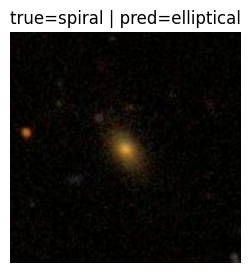

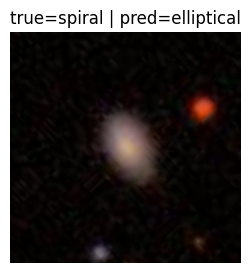

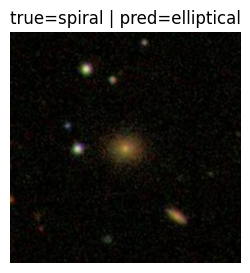

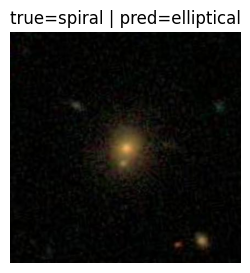

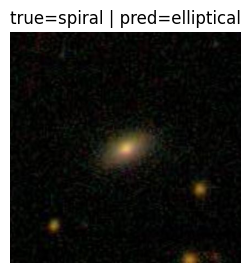

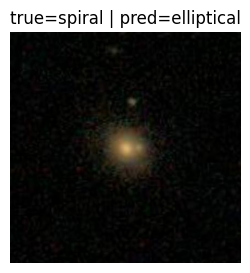

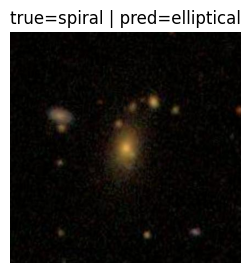

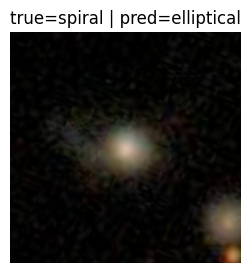

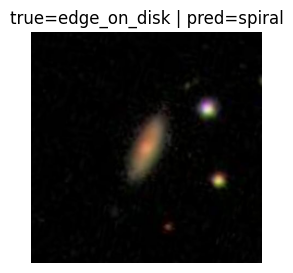

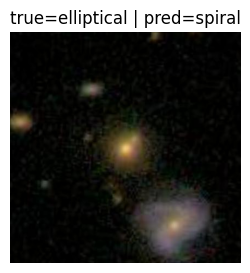

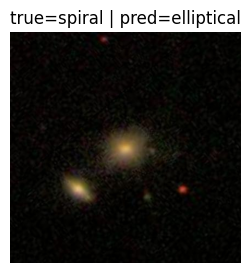

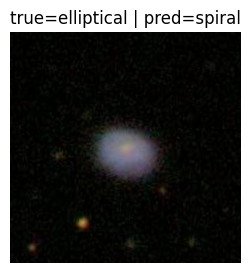

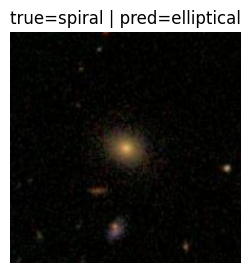

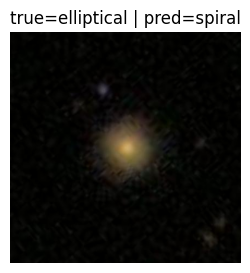

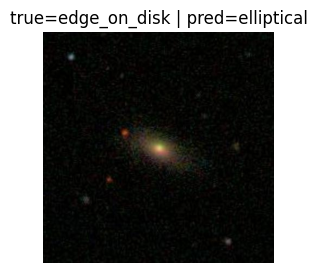

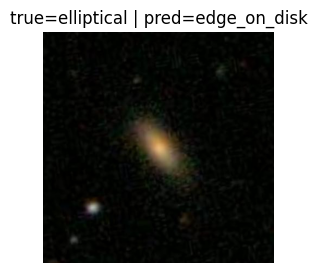

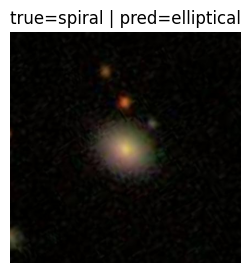

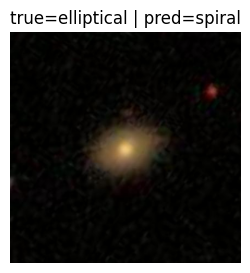

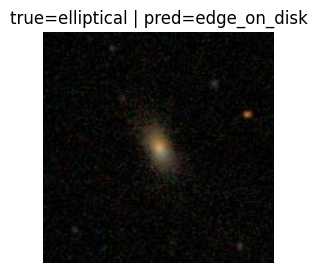

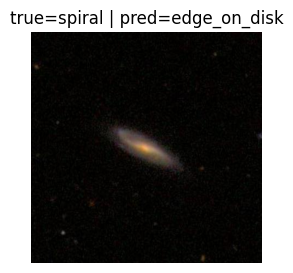

In [ ]:

import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from PIL import Image
import random
import torchvision
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_PATH = "/content/best_galaxy_v2_3class_SAFE.pt"

model = torchvision.models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 3)
model = model.to(device).to(memory_format=torch.channels_last)
model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
model.eval()

id2name = {0:"elliptical", 1:"spiral", 2:"edge_on_disk"}

@torch.no_grad()
def predict_all(loader):
    y_true, y_pred = [], []
    for X, y in loader:
        X = X.to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
        logits = model(X)
        preds = logits.argmax(1).cpu().numpy()
        y_pred.append(preds)
        y_true.append(y.numpy())
    return np.concatenate(y_true), np.concatenate(y_pred)

def print_metrics(name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    print(f"\n{name} Confusion Matrix:\n{cm}\n")
    names = [id2name[i] for i in [0,1,2]]
    print(f"{name} Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=names, digits=4))

y_true_val, y_pred_val = predict_all(val_loader)
print_metrics("VAL", y_true_val, y_pred_val)

y_true_test, y_pred_test = predict_all(test_loader)
print_metrics("TEST", y_true_test, y_pred_test)

try:
    test_df_reset = test_df.reset_index(drop=True).copy()
    test_df_reset["pred_id"] = y_pred_test
    wrong_idx = np.where(test_df_reset["label_id"].to_numpy() != test_df_reset["pred_id"].to_numpy())[0]
    print("\nWrong predictions:", len(wrong_idx), "out of", len(test_df_reset))

    show = random.sample(list(wrong_idx), k=min(20, len(wrong_idx)))
    for i in show:
        row = test_df_reset.iloc[i]
        img = Image.open(row["image_path"]).convert("RGB")
        plt.figure(figsize=(3,3))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"true={id2name[int(row['label_id'])]} | pred={id2name[int(row['pred_id'])]}")
        plt.show()
except Exception as e:
    print("\nSkipped wrong-example plots (test_df not found in memory). Error:", e)